In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install livelossplot

# Les librairies


In [3]:
# import des librairies
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import joblib
import livelossplot
import random
import shutil

from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img #data augmentation


# Dataset MMU-Iris-Database à modifier pour oeil gauche et droit
### Séparation et data augmentation à réaliser uniquement la première fois, sur le premier notebook utilisé, car identique aux 3

## Séparation du dataset en 'TRAIN', 'VALID' & 'TEST' pour oeil gauche et droit

#### Tirage aléatoire pour création du dossier 'test'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database'

# Création du dossier de test
dossier_test = os.path.join(MMU_Iris_Database, 'test')
os.makedirs(dossier_test, exist_ok=True)

# Parcourir les dossiers numérotés
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        dossier_droit = os.path.join(dossier_num, 'right')
        dossier_gauche = os.path.join(dossier_num, 'left')

        images_droit = os.listdir(dossier_droit)
        images_gauche = os.listdir(dossier_gauche)

        # Tirage aléatoire d'une image pour chaque côté
        image_droit_choisie = random.choice(images_droit)
        image_gauche_choisie = random.choice(images_gauche)

        # Chemins complets des images choisies
        chemin_image_droit = os.path.join(dossier_droit, image_droit_choisie)
        chemin_image_gauche = os.path.join(dossier_gauche, image_gauche_choisie)

        # Création des dossiers dans le dossier de test
        dossier_test_num = os.path.join(dossier_test, str(num_dossier))
        os.makedirs(os.path.join(dossier_test_num, 'right'), exist_ok=True)
        os.makedirs(os.path.join(dossier_test_num, 'left'), exist_ok=True)

        # Chemins complets pour copier les images dans le dossier de test
        chemin_image_droit_test = os.path.join(dossier_test_num, 'right', image_droit_choisie)
        chemin_image_gauche_test = os.path.join(dossier_test_num, 'left', image_gauche_choisie)

        # Copie des images choisies dans le dossier de test
        shutil.copy(chemin_image_droit, chemin_image_droit_test)
        shutil.copy(chemin_image_gauche, chemin_image_gauche_test)

        # Suppression des images originales
        os.remove(chemin_image_droit)
        os.remove(chemin_image_gauche)


FileNotFoundError: ignored

#### Tirage aléatoire pour création du dossier 'valid'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database'

# Création du dossier de validation
dossier_valid = os.path.join(MMU_Iris_Database, 'valid')
os.makedirs(dossier_valid, exist_ok=True)

# Parcourir les dossiers numérotés
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        dossier_droit = os.path.join(dossier_num, 'right')
        dossier_gauche = os.path.join(dossier_num, 'left')

        images_droit = os.listdir(dossier_droit)
        images_gauche = os.listdir(dossier_gauche)

        # Tirage aléatoire d'une image pour chaque côté
        image_droit_choisie = random.choice(images_droit)
        image_gauche_choisie = random.choice(images_gauche)

        # Chemins complets des images choisies
        chemin_image_droit = os.path.join(dossier_droit, image_droit_choisie)
        chemin_image_gauche = os.path.join(dossier_gauche, image_gauche_choisie)

        # Création des dossiers dans le dossier de valid
        dossier_valid_num = os.path.join(dossier_valid, str(num_dossier))
        os.makedirs(os.path.join(dossier_valid_num, 'right'), exist_ok=True)
        os.makedirs(os.path.join(dossier_valid_num, 'left'), exist_ok=True)

        # Chemins complets pour copier les images dans le dossier de test
        chemin_image_droit_valid = os.path.join(dossier_valid_num, 'right', image_droit_choisie)
        chemin_image_gauche_valid = os.path.join(dossier_valid_num, 'left', image_gauche_choisie)

        # Copie des images choisies dans le dossier de test
        shutil.copy(chemin_image_droit, chemin_image_droit_valid)
        shutil.copy(chemin_image_gauche, chemin_image_gauche_valid)

        # Suppression des images originales
        os.remove(chemin_image_droit)
        os.remove(chemin_image_gauche)

#### Regrouper les dossiers numérotés restants dans le dossier 'train'

In [ ]:
# Chemin vers le dossier principal
MMU_Iris_Database = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database'

# Chemin vers le dossier 'train'
dossier_train = os.path.join(MMU_Iris_Database, 'train')
os.makedirs(dossier_train, exist_ok=True)

# Déplacement des dossiers numérotés vers le dossier 'train'
for num_dossier in range(1, 47):
    if num_dossier != 4:  # Ignorer le dossier manquant '4'
        dossier_num = os.path.join(MMU_Iris_Database, str(num_dossier))
        shutil.move(dossier_num, dossier_train)

## Data augmentation pour entrainement des modèles pour oeil gauche et droit
(Ne lancer qu'une seule fois sur le dossier 'train', 'valid' et 'test')

#### Data augmentation pour le 'train'

In [ ]:
# chemins vers dossier
input_dir = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database/train'

# générateur d'image augmentée
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

#### Data augmentation pour le 'valid'

In [ ]:
# chemins vers dossier
input_dir = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database/valid'

# générateur d'image augmentée
datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

#### Data augmentation pour le 'test'

In [ ]:
# chemins vers dossier
input_dir = '/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/MMU-Iris-Database/test'

# générateur d'image augmentée (zoom)
datagen = ImageDataGenerator(
    brightness_range=[0.4, 0.9],  # ajuster la plage de la luminosité
    width_shift_range=0.1,  # ajuster la plage du décalage horizontal
    height_shift_range=0.1, # ajuster la plage du décalage horizontal
    fill_mode='nearest'
)

# boucle pour parcourir chaque image et sauvegarder la nouvelle image
for folder_name in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder_name)
    if os.path.isdir(folder_path):
        for sous_dossier in os.listdir(folder_path):
            sous_dossier_path = os.path.join(folder_path, sous_dossier)
            if os.path.isdir(sous_dossier_path):
                for image_name in os.listdir(sous_dossier_path):
                    if image_name.endswith('.bmp'):
                        image_path = os.path.join(sous_dossier_path, image_name)
                        img = load_img(image_path)
                        x = img_to_array(img)
                        x = x.reshape((1,) + x.shape)

                        i = 0
                        for batch in datagen.flow(x, batch_size=1, save_to_dir=sous_dossier_path, save_prefix=image_name.split('.')[0], save_format='bmp'):
                            i += 1
                            if i >= 5:  # Une seule copie zoomée par image
                                break

## Les fonctions

In [4]:
## Prétraitement de l'image : redimensionnemennt et standardization
def preprocess_img(img,new_dim=(240,320)):
    new_img=cv2.resize(img, (new_dim[1],new_dim[0]), interpolation = cv2.INTER_AREA)
    # Normalisation en divisant par 255
    last_img = new_img / 255.0
    return last_img

## Récupération des images

In [5]:
# Chemin vers les dossier principaux 'train', 'valid' & 'test' contenant les sous-dossiers
main_folder_train = '/content/drive/MyDrive/Dev/Simplon/cas_pratique/MMU-Iris-Database/train'
img_dim=(240,320,3)

main_folder_test = '/content/drive/MyDrive/Dev/Simplon/cas_pratique/MMU-Iris-Database/test'
img_dim=(240,320,3)

main_folder_valid = '/content/drive/MyDrive/Dev/Simplon/cas_pratique/MMU-Iris-Database/valid'
img_dim=(240,320,3)

## Préparation de la dataset

#### Oeil gauche en fonction de la personne

In [6]:
# TRAIN
X_left_train = []
Y_left_train = []

for target_folder in os.listdir(main_folder_train):
    target_path = os.path.join(main_folder_train, target_folder)

    if os.path.isdir(target_path):
        for side in ['left']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img(cv2.imread(image_path), img_dim)
                        X_left_train.append(image)
                        Y_left_train.append(target)

In [7]:
# VALID
X_left_valid = []
Y_left_valid = []

for target_folder in os.listdir(main_folder_valid):
    target_path = os.path.join(main_folder_valid, target_folder)

    if os.path.isdir(target_path):
        for side in ['left']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img(cv2.imread(image_path), img_dim)
                        X_left_valid.append(image)
                        Y_left_valid.append(target)


In [8]:
# TEST
X_left_test = []
Y_left_test = []

for target_folder in os.listdir(main_folder_test):
    target_path = os.path.join(main_folder_test, target_folder)

    if os.path.isdir(target_path):
        for side in ['left']:
            side_path = os.path.join(target_path, side)
            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img(cv2.imread(image_path), img_dim)
                        X_left_test.append(image)
                        Y_left_test.append(target)


In [9]:
# Nb images dans chaque variables
print(len(X_left_train), len(Y_left_train))
print(len(X_left_valid), len(Y_left_valid))
print(len(X_left_test), len(Y_left_test))

810 810
270 270
270 270


In [10]:
# TRAIN
pd.Series(Y_left_train).value_counts()

8     18
38    18
14    18
10    18
21    18
39    18
26    18
6     18
22    18
31    18
5     18
28    18
41    18
27    18
33    18
9     18
19    18
25    18
18    18
11    18
40    18
17    18
32    18
35    18
45    18
43    18
12    18
15    18
46    18
2     18
20    18
24    18
34    18
1     18
23    18
29    18
3     18
16    18
44    18
42    18
37    18
36    18
30    18
13    18
7     18
Name: count, dtype: int64

In [11]:
# TEST
pd.Series(Y_left_test).value_counts()

12    6
23    6
20    6
11    6
31    6
45    6
10    6
24    6
1     6
29    6
35    6
36    6
3     6
14    6
5     6
6     6
17    6
43    6
8     6
9     6
38    6
22    6
7     6
34    6
25    6
30    6
40    6
27    6
32    6
46    6
16    6
33    6
26    6
15    6
42    6
28    6
44    6
39    6
37    6
18    6
41    6
2     6
13    6
21    6
19    6
Name: count, dtype: int64

In [12]:
# VALID
pd.Series(Y_left_valid).value_counts()

1     6
10    6
11    6
6     6
43    6
46    6
38    6
12    6
7     6
41    6
32    6
9     6
19    6
31    6
2     6
17    6
29    6
30    6
3     6
40    6
8     6
34    6
26    6
22    6
44    6
27    6
25    6
5     6
21    6
13    6
16    6
42    6
35    6
28    6
39    6
15    6
37    6
33    6
18    6
23    6
24    6
36    6
45    6
14    6
20    6
Name: count, dtype: int64

## Encodage

#### Dataset base pour déterminer à qui appartient l'oeil

In [13]:
# TRAIN
labelEnc_left=preprocessing.LabelEncoder()
Y_enc_left_train=labelEnc_left.fit_transform(Y_left_train)

In [14]:
# VALID
labelEnc_left=preprocessing.LabelEncoder()
Y_enc_left_valid=labelEnc_left.fit_transform(Y_left_valid)

In [15]:
# TEST
labelEnc_left=preprocessing.LabelEncoder()
Y_enc_left_test=labelEnc_left.fit_transform(Y_left_test)

In [16]:
# Sauvegarde de l'encodeur
joblib.dump(labelEnc_left, '/content/drive/MyDrive/Dev/Simplon/cas_pratique/joblib/encodeur/encodeur_left.joblib')

['/content/drive/MyDrive/Dev/Simplon/cas_pratique/joblib/encodeur/encodeur_left.joblib']

#### Categorical pour dataset base

In [17]:
# oeil gauche
y_train_enc_left=to_categorical(Y_enc_left_train)
y_test_enc_left=to_categorical(Y_enc_left_test)
y_valid_enc_left=to_categorical(Y_enc_left_valid)

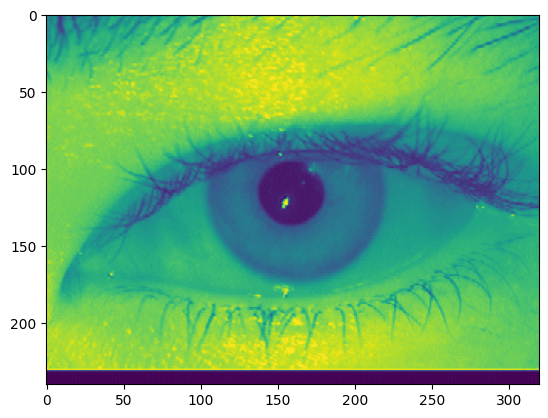

In [18]:
# permet d'afficher une des images de l'oeil gauche
plt.imshow(X_left_train[0][:,:,2])

## Entrainement du modèle et affichage des performances pour oeil droit et gauche

In [19]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50

NBCLASSES = 45
IMSIZE=[240,320]

def create_model():
    # vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)
    resnet = ResNet50(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Freeze existing VGG already trained weights

    for layer in resnet.layers:
        layer.trainable = False

    # get the VGG output
    out = resnet.output

    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    model = Model(inputs=resnet.input, outputs=x)

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    model.summary()

    return model

left_model = create_model()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 240, 320, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 326, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 160, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                       

## Oeil gauche

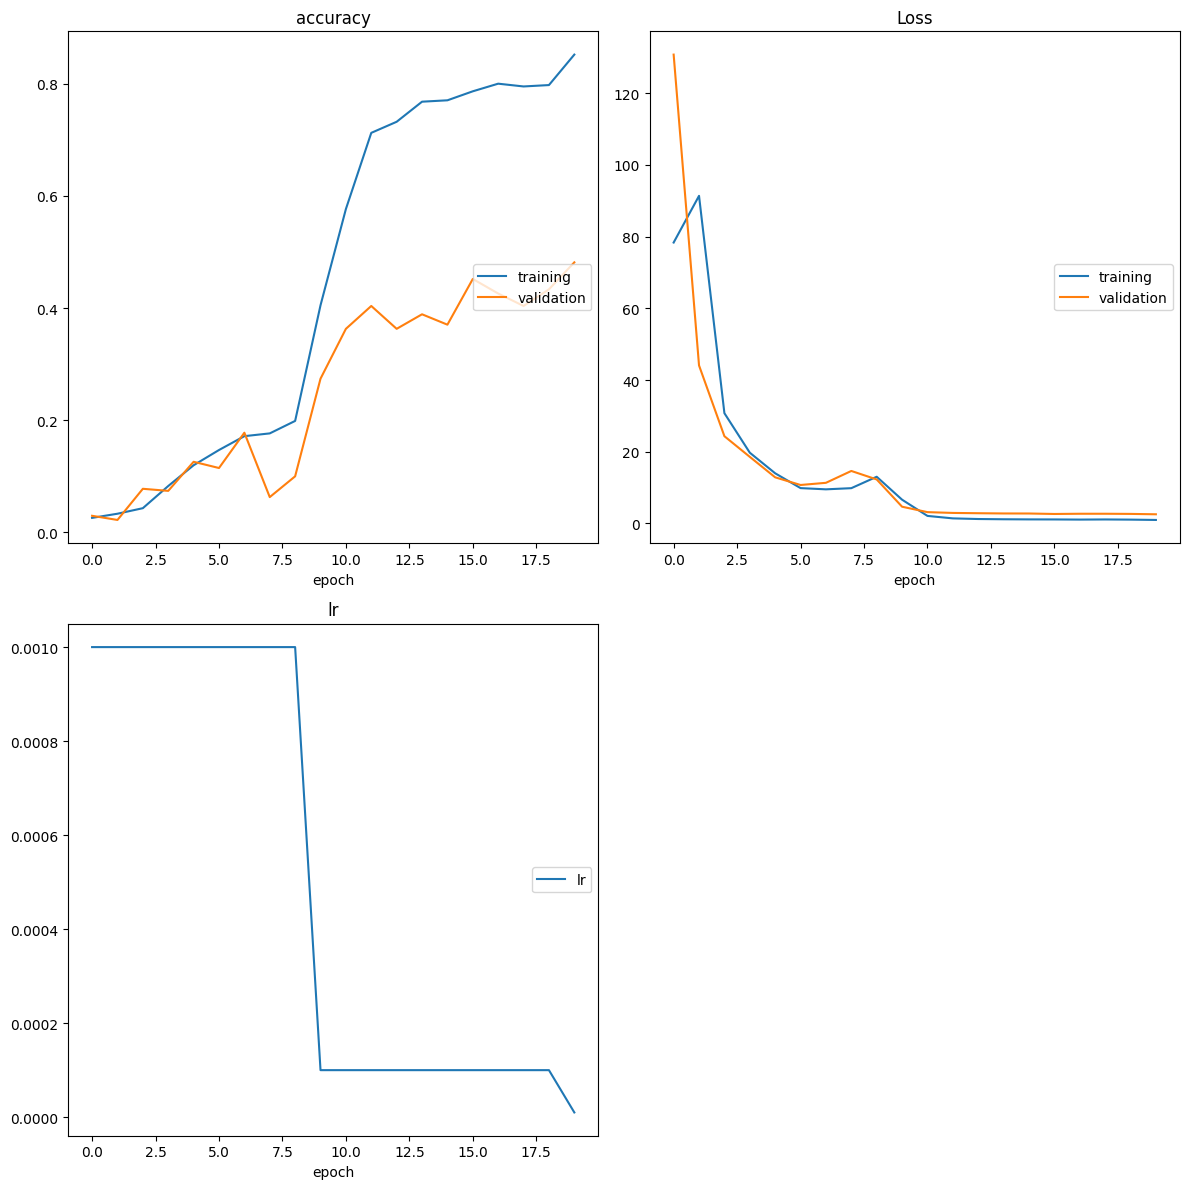

accuracy
	training         	 (min:    0.026, max:    0.852, cur:    0.852)
	validation       	 (min:    0.022, max:    0.481, cur:    0.481)
Loss
	training         	 (min:    0.977, max:   91.370, cur:    0.977)
	validation       	 (min:    2.558, max:  130.760, cur:    2.558)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
27/27 [==============================] - 6s 225ms/step - loss: 0.9771 - accuracy: 0.8519 - val_loss: 2.5580 - val_accuracy: 0.4815 - lr: 1.0000e-05


In [22]:
hist = left_model.fit(np.array(X_left_train), np.array(y_train_enc_left), batch_size = 30, epochs = 20, validation_data=(np.array(X_left_valid), np.array(y_valid_enc_left)),callbacks=[rlrop,early,PlotLossesKeras()])

In [23]:
# Données de test

y_test_pred_left = [np.argmax(v) for v in left_model.predict(np.array(X_left_test))]  # Prédictions du modèle

9/9 [==============================] - 7s 356ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 1]]
Précision : 0.50
Rappel : 0.46
Score F1 : 0.44
Exactitude : 0.46


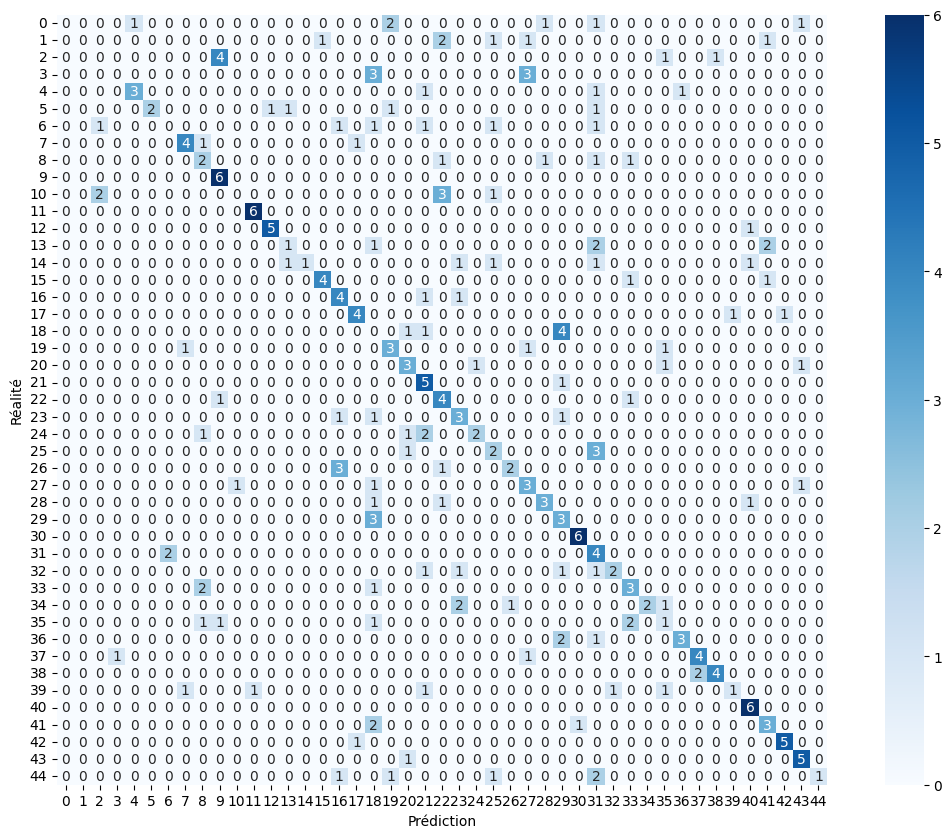

In [24]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(Y_enc_left_test), np.array(y_test_pred_left))

# # Calcul des mesures de performance
accuracy = accuracy_score(Y_enc_left_test, y_test_pred_left)
precision = precision_score(Y_enc_left_test, y_test_pred_left,average='macro')
recall = recall_score(Y_enc_left_test, y_test_pred_left,average='macro')
f1 = f1_score(Y_enc_left_test, y_test_pred_left,average='macro')

print("Matrice de confusion :")
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.imshow(conf_matrix)
print(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

## Sauvegarde des modèles

In [ ]:
left_model.save('/content/drive/MyDrive/cas_pratique/CAS_PRATIQUES/models/left_eye')